<a href="https://colab.research.google.com/github/Ameer-sayyad/SLFI_Task2/blob/main/Emotion_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#STEP 1 — Setup environment

In [ ]:
!pip install librosa
!pip install transformers
!pip install soundfile
!pip install torch torchaudio


#STEP 2 — Mount Google Drive in Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


#Speech Pipeline

In [ ]:
import os
import shutil
import random
from collections import defaultdict

# original dataset location (Google Drive)
source_path = "/content/drive/MyDrive/Emotion_dataset/TESS Toronto emotional speech set data"

# new split location (Colab runtime)
split_path = "/content/TESS_SPLIT"

train_dir = os.path.join(split_path, "train")
test_dir = os.path.join(split_path, "test")

emotions = ["angry","disgust","fear","happy","ps","sad","neutral"]

# create train/test emotion folders
for base in [train_dir, test_dir]:
    for emo in emotions:
        os.makedirs(os.path.join(base, emo), exist_ok=True)

print("Folders created successfully.")


Folders created successfully.


In [ ]:
import os

source_path = "/content/drive/MyDrive/Emotion_dataset/TESS Toronto emotional speech set data"

for folder in os.listdir(source_path):
    folder_path = os.path.join(source_path, folder)

    for file in os.listdir(folder_path)[:5]:   # show first 5 files only
        print(file)

    break


YAF_kite_disgust.wav
YAF_long_disgust.wav
YAF_keg_disgust.wav
YAF_lid_disgust.wav
YAF_beg_disgust.wav


In [ ]:
from collections import defaultdict
import os

source_path = "/content/drive/MyDrive/Emotion_dataset/TESS Toronto emotional speech set data"

emotion_files = defaultdict(lambda: {"YAF": [], "OAF": []})

for folder in os.listdir(source_path):
    folder_path = os.path.join(source_path, folder)

    for file in os.listdir(folder_path):
        if file.endswith(".wav"):

            speaker = file[:3]   # first 3 chars
            emotion = file.split("_")[-1].replace(".wav","").lower()

            full_path = os.path.join(folder_path, file)

            if speaker in ["YAF", "OAF"]:
                emotion_files[emotion][speaker].append(full_path)

print("Grouping completed.")


Grouping completed.


In [ ]:
for emo in emotion_files:
    print(
        emo,
        "YAF:", len(emotion_files[emo]["YAF"]),
        "OAF:", len(emotion_files[emo]["OAF"])
    )


disgust YAF: 200 OAF: 200
ps YAF: 200 OAF: 200
happy YAF: 200 OAF: 200
sad YAF: 200 OAF: 200
neutral YAF: 200 OAF: 199
fear YAF: 200 OAF: 200
angry YAF: 200 OAF: 200


In [ ]:
split_path = "/content/TESS_SPLIT"

train_dir = os.path.join(split_path, "train")
test_dir = os.path.join(split_path, "test")

emotions = ["angry","disgust","fear","happy","ps","sad","neutral"]

for base in [train_dir, test_dir]:
    for emo in emotions:
        os.makedirs(os.path.join(base, emo), exist_ok=True)

print("Train/Test folders created.")


Train/Test folders created.


In [ ]:
import random
import shutil

for emotion in emotions:

    yaf_files = emotion_files[emotion]["YAF"]
    oaf_files = emotion_files[emotion]["OAF"]

    random.shuffle(yaf_files)
    random.shuffle(oaf_files)

    # select test files
    test_yaf = yaf_files[:40]
    test_oaf = oaf_files[:40]

    train_yaf = yaf_files[40:]
    train_oaf = oaf_files[40:]

    # copy test files
    for file in test_yaf + test_oaf:
        shutil.copy(file, os.path.join(test_dir, emotion))

    # copy train files
    for file in train_yaf + train_oaf:
        shutil.copy(file, os.path.join(train_dir, emotion))

print("Speaker-balanced split completed.")


KeyboardInterrupt: 

In [ ]:
for emo in emotions:
    train_count = len(os.listdir(os.path.join(train_dir, emo)))
    test_count = len(os.listdir(os.path.join(test_dir, emo)))

    print(f"{emo} → Train: {train_count} | Test: {test_count}")


angry → Train: 320 | Test: 80
disgust → Train: 320 | Test: 80
fear → Train: 320 | Test: 80
happy → Train: 320 | Test: 80
ps → Train: 320 | Test: 80
sad → Train: 320 | Test: 80
neutral → Train: 319 | Test: 80


In [ ]:
train_base = "/content/TESS_SPLIT/train"
test_base  = "/content/TESS_SPLIT/test"

emotion_map = {
    "angry":0,
    "disgust":1,
    "fear":2,
    "happy":3,
    "ps":4,
    "sad":5,
    "neutral":6
}

train_paths = []
train_labels = []

test_paths = []
test_labels = []

# load train
for emo in os.listdir(train_base):
    emo_path = os.path.join(train_base, emo)

    for file in os.listdir(emo_path):
        train_paths.append(os.path.join(emo_path, file))
        train_labels.append(emotion_map[emo])

# load test
for emo in os.listdir(test_base):
    emo_path = os.path.join(test_base, emo)

    for file in os.listdir(emo_path):
        test_paths.append(os.path.join(emo_path, file))
        test_labels.append(emotion_map[emo])

print("Train samples:", len(train_paths))
print("Test samples:", len(test_paths))


Train samples: 2239
Test samples: 560


In [ ]:
import torch
import librosa
from transformers import HubertModel, Wav2Vec2FeatureExtractor

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/hubert-base-ls960")
hubert_model = HubertModel.from_pretrained("facebook/hubert-base-ls960").to(device)


In [ ]:
train_embed_dir = "/content/hubert_train_embeddings"
test_embed_dir  = "/content/hubert_test_embeddings"

os.makedirs(train_embed_dir, exist_ok=True)
os.makedirs(test_embed_dir, exist_ok=True)


In [ ]:
def extract_hubert(audio_path):

    speech, sr = librosa.load(audio_path, sr=16000)

    inputs = feature_extractor(
        speech,
        sampling_rate=16000,
        return_tensors="pt",
        padding=True
    )

    input_values = inputs.input_values.to(device)

    with torch.no_grad():
        outputs = hubert_model(input_values)

    # shape → [time_frames, 768]
    embedding = outputs.last_hidden_state.squeeze(0)

    return embedding.cpu()


In [ ]:
from tqdm import tqdm

for path in tqdm(train_paths):
    emb = extract_hubert(path)

    file_name = path.split("/")[-1].replace(".wav", ".pt")
    torch.save(emb, os.path.join(train_embed_dir, file_name))


100%|██████████| 2239/2239 [00:43<00:00, 51.58it/s]


In [ ]:
for path in tqdm(test_paths):
    emb = extract_hubert(path)

    file_name = path.split("/")[-1].replace(".wav", ".pt")
    torch.save(emb, os.path.join(test_embed_dir, file_name))


100%|██████████| 560/560 [00:10<00:00, 51.62it/s]


In [ ]:
def load_train_embedding(path):
    file_name = path.split("/")[-1].replace(".wav", ".pt")
    return torch.load(os.path.join(train_embed_dir, file_name))

def load_test_embedding(path):
    file_name = path.split("/")[-1].replace(".wav", ".pt")
    return torch.load(os.path.join(test_embed_dir, file_name))


In [ ]:
import torch.nn as nn

class EmotionBiLSTM(nn.Module):
    def __init__(self):
        super(EmotionBiLSTM, self).__init__()

        # BiLSTM layer
        self.lstm = nn.LSTM(
            input_size=768,
            hidden_size=128,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )

        # Dense classifier
        self.fc = nn.Linear(256, 7)

    def forward(self, x):

        # x shape → [T, 768]
        x = x.unsqueeze(0)   # → [1, T, 768]

        lstm_out, _ = self.lstm(x)   # → [1, T, 256]

        # mean pooling across time
        pooled = lstm_out.mean(dim=1)   # → [1, 256]

        output = self.fc(pooled)   # → [1, 7]

        return output


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = EmotionBiLSTM().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

epochs = 23


In [ ]:
for epoch in range(epochs):

    model.train()
    total_loss = 0

    for path, label in zip(train_paths, train_labels):

        features = load_train_embedding(path).unsqueeze(0).to(device)
        label_tensor = torch.tensor([label]).to(device)

        outputs = model(features)
        loss = criterion(outputs, label_tensor)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1} Loss:", total_loss)


Epoch 1 Loss: 1157.858790819766
Epoch 2 Loss: 914.0774791026488
Epoch 3 Loss: 727.335479141213
Epoch 4 Loss: 623.132951237727
Epoch 5 Loss: 506.66641547111794
Epoch 6 Loss: 452.66497655876447
Epoch 7 Loss: 343.60437360592186
Epoch 8 Loss: 261.29889087745687
Epoch 9 Loss: 201.8631043419009
Epoch 10 Loss: 145.06195570612908
Epoch 11 Loss: 134.16371235697443
Epoch 12 Loss: 89.48941970115266
Epoch 13 Loss: 67.02946837228956
Epoch 14 Loss: 54.13865389286366
Epoch 15 Loss: 56.742080933996476
Epoch 16 Loss: 46.1649867115957
Epoch 17 Loss: 27.09008732118764
Epoch 18 Loss: 16.44793585363641
Epoch 19 Loss: 24.374543047001225
Epoch 20 Loss: 11.893350894725472
Epoch 21 Loss: 15.617766952384386
Epoch 22 Loss: 12.94715012608367
Epoch 23 Loss: 9.976070069439857


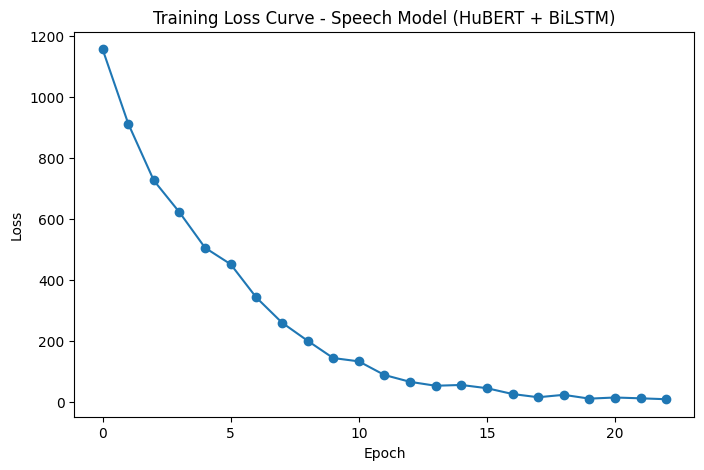

In [ ]:
import matplotlib.pyplot as plt
import os
import pandas as pd

results_path = "/content/drive/MyDrive/Speech_Emotion_Project/Results"
plots_path = os.path.join(results_path, "plots")

loss_values = [
1157.85,914.07,727.33,623.13,506.66,452.66,343.60,261.29,201.86,
145.06,134.16,89.48,67.02,54.13,56.74,46.16,27.09,16.44,24.37,
11.89,15.61,12.94,9.97
]

# Save CSV
df = pd.DataFrame({"Epoch": range(1,len(loss_values)+1),
                   "Loss": loss_values})
df.to_csv(os.path.join(results_path,"speech_training_loss.csv"), index=False)

# Plot
plt.figure(figsize=(8,5))
plt.plot(loss_values, marker='o')
plt.title("Training Loss Curve - Speech Model (HuBERT + BiLSTM)")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.savefig(os.path.join(plots_path,"speech_loss_curve.png"))
plt.show()


In [ ]:
torch.save(
    model.state_dict(),
    "/content/drive/MyDrive/Speech_Emotion_Project/final_hubert_bilstm.pt"
)


#Text sentence
   ↓
BERT tokenizer
   ↓
BERT embeddings
   ↓
CLS token representation
   ↓
Dense layer
   ↓
Softmax
   ↓
Emotion


#STEP 1 — Build text dataset from filenames

In [ ]:
import os

train_base = "/content/TESS_SPLIT/train"
test_base  = "/content/TESS_SPLIT/test"

emotion_map = {
    "angry":0,
    "disgust":1,
    "fear":2,
    "happy":3,
    "ps":4,
    "sad":5,
    "neutral":6
}

train_paths = []
train_labels = []

test_paths = []
test_labels = []

# load train data
for emo in os.listdir(train_base):
    emo_path = os.path.join(train_base, emo)

    for file in os.listdir(emo_path):
        train_paths.append(os.path.join(emo_path, file))
        train_labels.append(emotion_map[emo])

# load test data
for emo in os.listdir(test_base):
    emo_path = os.path.join(test_base, emo)

    for file in os.listdir(emo_path):
        test_paths.append(os.path.join(emo_path, file))
        test_labels.append(emotion_map[emo])

print("Train samples:", len(train_paths))
print("Test samples:", len(test_paths))


Train samples: 1048
Test samples: 424


In [ ]:
def build_text_dataset(paths, labels):
    texts = []

    for path in paths:
        file = path.split("/")[-1]
        word = file.split("_")[1]   # extract main word

        sentence = f"say the word {word}"
        texts.append(sentence)

    return texts, labels

train_texts, train_labels_text = build_text_dataset(train_paths, train_labels)
test_texts, test_labels_text = build_text_dataset(test_paths, test_labels)

print(train_texts[:5])


['say the word neat', 'say the word mop', 'say the word chain', 'say the word doll', 'say the word reach']


In [ ]:
!pip install transformers


In [ ]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


Using device: cuda


In [ ]:
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased").to(device)


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [ ]:
sample_text = train_texts[0]

inputs = tokenizer(sample_text,
                   return_tensors="pt",
                   truncation=True,
                   padding=True,
                   max_length=16).to(device)

with torch.no_grad():
    outputs = bert_model(**inputs)

cls_embedding = outputs.last_hidden_state[:,0,:]

print("Embedding shape:", cls_embedding.shape)


Embedding shape: torch.Size([1, 768])


In [ ]:
import torch.nn as nn

class TextEmotionClassifier(nn.Module):
    def __init__(self, input_dim=768, num_classes=7):
        super().__init__()
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return self.fc(x)


In [ ]:
text_model = TextEmotionClassifier().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(text_model.parameters(), lr=2e-5)

epochs = 30


In [ ]:
epoch_losses_text = []

for epoch in range(epochs):

    text_model.train()
    total_loss = 0

    for text, label in zip(train_texts, train_labels_text):

        inputs = tokenizer(text,
                           return_tensors="pt",
                           truncation=True,
                           padding=True,
                           max_length=16).to(device)

        with torch.no_grad():
            outputs = bert_model(**inputs)

        cls_embedding = outputs.last_hidden_state[:,0,:]

        label_tensor = torch.tensor([label]).to(device)

        preds = text_model(cls_embedding)
        loss = criterion(preds, label_tensor)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    epoch_losses_text.append(total_loss)
    print(f"Epoch {epoch+1} Loss:", total_loss)


Epoch 1 Loss: 1581.5703842639923
Epoch 2 Loss: 1214.4663063585758
Epoch 3 Loss: 1196.4948194026947
Epoch 4 Loss: 1186.432089149952
Epoch 5 Loss: 1180.7685363292694
Epoch 6 Loss: 1177.6400457918644
Epoch 7 Loss: 1175.8112647533417
Epoch 8 Loss: 1174.6728990375996
Epoch 9 Loss: 1173.920658916235
Epoch 10 Loss: 1173.392744243145
Epoch 11 Loss: 1172.9985652267933
Epoch 12 Loss: 1172.6856350004673
Epoch 13 Loss: 1172.4230233728886
Epoch 14 Loss: 1172.1921314895153
Epoch 15 Loss: 1171.981765717268
Epoch 16 Loss: 1171.785133868456
Epoch 17 Loss: 1171.5981537103653
Epoch 18 Loss: 1171.4182219803333
Epoch 19 Loss: 1171.2439333498478
Epoch 20 Loss: 1171.0741814672947
Epoch 21 Loss: 1170.9084058701992
Epoch 22 Loss: 1170.7460645139217
Epoch 23 Loss: 1170.5870022773743
Epoch 24 Loss: 1170.4310930371284
Epoch 25 Loss: 1170.277896553278
Epoch 26 Loss: 1170.1277549564838
Epoch 27 Loss: 1169.979907810688
Epoch 28 Loss: 1169.8348224759102
Epoch 29 Loss: 1169.692293047905
Epoch 30 Loss: 1169.55221408605

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

text_model.eval()
preds_text = []

for text in test_texts:

    inputs = tokenizer(text,
                       return_tensors="pt",
                       truncation=True,
                       padding=True,
                       max_length=16).to(device)

    with torch.no_grad():
        outputs = bert_model(**inputs)

    cls_embedding = outputs.last_hidden_state[:,0,:]

    pred = torch.argmax(text_model(cls_embedding), dim=1).item()
    preds_text.append(pred)

acc_text = accuracy_score(test_labels_text, preds_text)

print("Text Model Accuracy:", acc_text)
print("\nClassification Report:\n")
print(classification_report(test_labels_text, preds_text))


Text Model Accuracy: 0.2759433962264151

Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       147
           1       0.28      1.00      0.43       117
           2       0.00      0.00      0.00        80
           3       0.00      0.00      0.00        80

    accuracy                           0.28       424
   macro avg       0.07      0.25      0.11       424
weighted avg       0.08      0.28      0.12       424



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


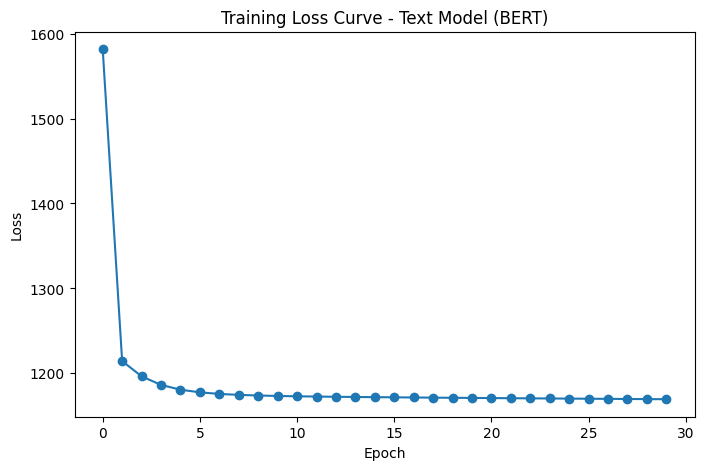

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(epoch_losses_text, marker='o')
plt.title("Training Loss Curve - Text Model (BERT)")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.savefig(os.path.join(plots_path, "text_loss_curve.png"))
plt.show()


#Multimodal Architecture

#STEP 2 — Fusion model

In [ ]:
import os
import torch
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


Device: cuda


In [ ]:
import os

train_base = "/content/drive/MyDrive/Speech_Emotion_Project/TESS_SPLIT/train"
test_base  = "/content/drive/MyDrive/Speech_Emotion_Project/TESS_SPLIT/test"

emotion_map = {
    "angry":0,
    "disgust":1,
    "fear":2,
    "happy":3,
    "ps":4,
    "sad":5,
    "neutral":6
}

train_paths = []
train_labels = []

test_paths = []
test_labels = []

# rebuild train list
for emo in os.listdir(train_base):
    emo_path = os.path.join(train_base, emo)

    for file in os.listdir(emo_path):
        train_paths.append(os.path.join(emo_path, file))
        train_labels.append(emotion_map[emo])

# rebuild test list
for emo in os.listdir(test_base):
    emo_path = os.path.join(test_base, emo)

    for file in os.listdir(emo_path):
        test_paths.append(os.path.join(emo_path, file))
        test_labels.append(emotion_map[emo])

print("Train:", len(train_paths))
print("Test:", len(test_paths))


Train: 2241
Test: 560


In [ ]:
def build_text_dataset(paths, labels):
    texts = []

    for path in paths:
        file = path.split("/")[-1]
        word = file.split("_")[1]
        sentence = f"say the word {word}"
        texts.append(sentence)

    return texts, labels

train_texts, train_labels_text = build_text_dataset(train_paths, train_labels)
test_texts, test_labels_text = build_text_dataset(test_paths, test_labels)

print(train_texts[:5])


['say the word lose', 'say the word cab', 'say the word bar', 'say the word dab', 'say the word raise']


In [ ]:
train_embed_dir = "/content/drive/MyDrive/Speech_Emotion_Project/hubert_train_embeddings"
test_embed_dir  = "/content/drive/MyDrive/Speech_Emotion_Project/hubert_test_embeddings"


In [ ]:
import torch
from transformers import BertTokenizer, BertModel

device = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased").to(device)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [ ]:
def load_train_embedding(path):
    file_name = path.split("/")[-1].replace(".wav", ".pt")
    emb_path = os.path.join(train_embed_dir, file_name)

    if os.path.exists(emb_path):
        return torch.load(emb_path)
    else:
        return None

def load_test_embedding(path):
    file_name = path.split("/")[-1].replace(".wav", ".pt")
    emb_path = os.path.join(test_embed_dir, file_name)

    if os.path.exists(emb_path):
        return torch.load(emb_path)
    else:
        return None


In [ ]:
import torch.nn as nn

class FusionEmotionModel(nn.Module):
    def __init__(self, speech_dim=768, text_dim=768, num_classes=7):
        super().__init__()

        self.fc1 = nn.Linear(speech_dim + text_dim, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, speech_emb, text_emb):
        fused = torch.cat((speech_emb, text_emb), dim=1)
        x = self.fc1(fused)
        x = self.relu(x)
        x = self.fc2(x)
        return x


In [ ]:
fusion_model = FusionEmotionModel().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fusion_model.parameters(), lr=1e-4)

epochs = 30


In [ ]:
epoch_losses_fusion = []

for epoch in range(epochs):

    fusion_model.train()
    total_loss = 0

    for path, text, label in zip(train_paths, train_texts, train_labels):

        speech_emb = load_train_embedding(path)
        if speech_emb is None:
            continue

        speech_emb = speech_emb.unsqueeze(0).to(device)
        speech_emb = speech_emb.mean(dim=1)

        inputs = tokenizer(text,
                           return_tensors="pt",
                           truncation=True,
                           padding=True,
                           max_length=16).to(device)

        with torch.no_grad():
            outputs = bert_model(**inputs)

        text_emb = outputs.last_hidden_state[:,0,:]

        label_tensor = torch.tensor([label]).to(device)

        preds = fusion_model(speech_emb, text_emb)
        loss = criterion(preds, label_tensor)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    epoch_losses_fusion.append(total_loss)
    print(f"Epoch {epoch+1} Loss:", total_loss)


Epoch 1 Loss: 2266.3639678875334
Epoch 2 Loss: 1740.0174978906289
Epoch 3 Loss: 1257.0189307630062
Epoch 4 Loss: 938.7769051976502
Epoch 5 Loss: 770.380390626844
Epoch 6 Loss: 648.7028507632203
Epoch 7 Loss: 562.6765678615775
Epoch 8 Loss: 487.50739665539004
Epoch 9 Loss: 441.22834718739614
Epoch 10 Loss: 386.94416697509587
Epoch 11 Loss: 343.2217530964408
Epoch 12 Loss: 309.32892488944344
Epoch 13 Loss: 277.6699582521105
Epoch 14 Loss: 252.27302727638744
Epoch 15 Loss: 228.8117371806875
Epoch 16 Loss: 208.88429514260497
Epoch 17 Loss: 191.07037130376557
Epoch 18 Loss: 176.61386665253667
Epoch 19 Loss: 164.09686419047648
Epoch 20 Loss: 154.4783464994689
Epoch 21 Loss: 145.32517873503093
Epoch 22 Loss: 136.67487114779942
Epoch 23 Loss: 129.48923533155175
Epoch 24 Loss: 122.98751789671223
Epoch 25 Loss: 116.65854029239927
Epoch 26 Loss: 112.28832344038892
Epoch 27 Loss: 106.94540584609058
Epoch 28 Loss: 101.96345798251423
Epoch 29 Loss: 97.34234925708915
Epoch 30 Loss: 93.65785987954587


In [ ]:
from sklearn.metrics import accuracy_score, classification_report

fusion_model.eval()
preds_fusion = []

for path, text in zip(test_paths, test_texts):

    speech_emb = load_test_embedding(path)
    if speech_emb is None:
        continue

    speech_emb = speech_emb.unsqueeze(0).to(device)
    speech_emb = speech_emb.mean(dim=1)

    inputs = tokenizer(text,
                       return_tensors="pt",
                       truncation=True,
                       padding=True,
                       max_length=16).to(device)

    with torch.no_grad():
        outputs = bert_model(**inputs)

    text_emb = outputs.last_hidden_state[:,0,:]

    pred = torch.argmax(fusion_model(speech_emb, text_emb), dim=1).item()
    preds_fusion.append(pred)

acc_fusion = accuracy_score(test_labels[:len(preds_fusion)], preds_fusion)

print("Fusion Model Accuracy:", acc_fusion)
print("\nClassification Report:\n")
print(classification_report(test_labels[:len(preds_fusion)], preds_fusion))


Fusion Model Accuracy: 0.3821428571428571

Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.16      0.28        80
           1       0.42      0.06      0.11        80
           2       0.14      0.03      0.04        80
           3       0.54      0.31      0.40        80
           4       0.96      0.62      0.76        80
           5       0.13      0.49      0.21        80
           6       0.64      1.00      0.78        80

    accuracy                           0.38       560
   macro avg       0.55      0.38      0.37       560
weighted avg       0.55      0.38      0.37       560



In [ ]:
import pandas as pd

pd.DataFrame({
    "Epoch": list(range(1, len(epoch_losses_fusion)+1)),
    "Loss": epoch_losses_fusion
}).to_csv(os.path.join(results_path, "fusion_training_loss.csv"), index=False)


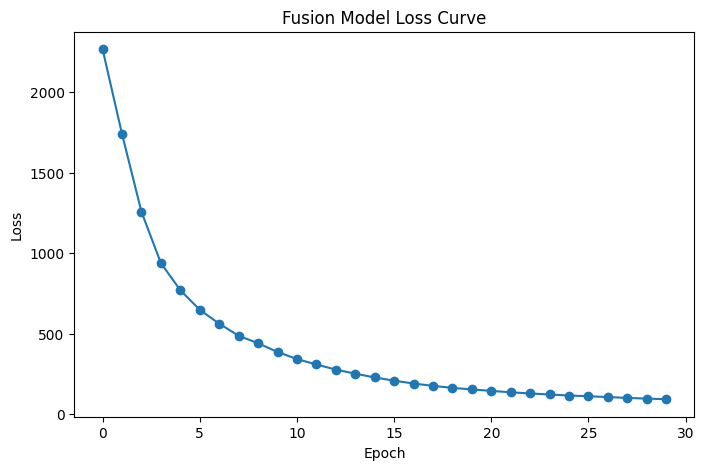

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(epoch_losses_fusion, marker='o')
plt.title("Fusion Model Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.savefig(os.path.join(plots_path, "fusion_loss_curve.png"))
plt.show()


#speech output

In [ ]:
import torch
import torch.nn as nn

class EmotionBiLSTM(nn.Module):
    def __init__(self, input_dim=768, hidden_dim=128, num_layers=1, num_classes=7):
        super().__init__()

        self.lstm = nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers=num_layers,
            bidirectional=True,
            batch_first=True
        )

        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]   # last time step
        out = self.fc(out)
        return out


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"


In [ ]:
speech_model_path = "/content/drive/MyDrive/Speech_Emotion_Project/final_hubert_bilstm.pt"

model = EmotionBiLSTM().to(device)
model.load_state_dict(torch.load(speech_model_path))
model.eval()

print("Speech model loaded.")


Speech model loaded.


In [ ]:
import os

test_embed_dir = "/content/drive/MyDrive/Speech_Emotion_Project/hubert_test_embeddings"

def load_test_embedding(path):
    file_name = path.split("/")[-1].replace(".wav", ".pt")
    return torch.load(os.path.join(test_embed_dir, file_name))


In [ ]:
preds = []

for path in test_paths:
    features = load_test_embedding(path).unsqueeze(0).to(device)
    outputs = model(features)
    pred = torch.argmax(outputs, dim=1).item()
    preds.append(pred)

print("Predictions:", len(preds))


Predictions: 560


In [ ]:
from sklearn.metrics import classification_report

speech_report = classification_report(test_labels, preds)
print(speech_report)

results_path = "/content/drive/MyDrive/Speech_Emotion_Project/Results"

with open(results_path + "/speech_classification_report.txt", "w") as f:
    f.write(speech_report)


              precision    recall  f1-score   support

           0       0.98      0.79      0.88        80
           1       1.00      0.94      0.97        80
           2       0.93      0.97      0.95        80
           3       0.93      0.81      0.87        80
           4       0.84      0.97      0.90        80
           5       0.81      1.00      0.89        80
           6       0.93      0.88      0.90        80

    accuracy                           0.91       560
   macro avg       0.92      0.91      0.91       560
weighted avg       0.92      0.91      0.91       560



In [ ]:
speech_train_code = '''
import os
import torch
import torch.nn as nn
from tqdm import tqdm

# ---------------------------
# PATHS
# ---------------------------
train_embed_dir = "/content/drive/MyDrive/Speech_Emotion_Project/hubert_train_embeddings"
train_split_path = "/content/drive/MyDrive/Speech_Emotion_Project/TESS_SPLIT/train"
model_save_path = "/content/drive/MyDrive/project/models/speech_pipeline/speech_model.pt"

# ---------------------------
# DEVICE
# ---------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"

# ---------------------------
# EMOTION MAP
# ---------------------------
emotion_map = {
    "angry":0,
    "disgust":1,
    "fear":2,
    "happy":3,
    "ps":4,
    "sad":5,
    "neutral":6
}

# ---------------------------
# LOAD TRAIN DATA
# ---------------------------
train_paths = []
train_labels = []

for emo in os.listdir(train_split_path):
    emo_path = os.path.join(train_split_path, emo)

    for file in os.listdir(emo_path):
        train_paths.append(os.path.join(emo_path, file))
        train_labels.append(emotion_map[emo])

# ---------------------------
# LOAD EMBEDDINGS
# ---------------------------
def load_train_embedding(path):
    file_name = path.split("/")[-1].replace(".wav",".pt")
    return torch.load(os.path.join(train_embed_dir,file_name))

# ---------------------------
# MODEL
# ---------------------------
class EmotionBiLSTM(nn.Module):
    def __init__(self,input_dim=768,hidden_dim=128,num_layers=1,num_classes=7):
        super().__init__()
        self.lstm = nn.LSTM(input_dim,hidden_dim,
                            num_layers=num_layers,
                            bidirectional=True,
                            batch_first=True)
        self.fc = nn.Linear(hidden_dim*2,num_classes)

    def forward(self,x):
        out,_ = self.lstm(x)
        out = out[:,-1,:]
        return self.fc(out)

model = EmotionBiLSTM().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)

epochs = 20

# ---------------------------
# TRAIN LOOP
# ---------------------------
for epoch in range(epochs):

    model.train()
    total_loss = 0

    for path,label in tqdm(zip(train_paths,train_labels), total=len(train_paths)):

        features = load_train_embedding(path).unsqueeze(0).to(device)
        label_tensor = torch.tensor([label]).to(device)

        outputs = model(features)
        loss = criterion(outputs,label_tensor)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1} Loss:", total_loss)

# ---------------------------
# SAVE MODEL
# ---------------------------
torch.save(model.state_dict(), model_save_path)
print("Speech model saved.")
'''


In [ ]:
speech_test_code = '''
import os
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, classification_report

# ---------------------------
# PATHS
# ---------------------------
model_path = "/content/drive/MyDrive/project/models/speech_pipeline/speech_model.pt"
test_embed_dir = "/content/drive/MyDrive/Speech_Emotion_Project/hubert_test_embeddings"
test_split_path = "/content/drive/MyDrive/Speech_Emotion_Project/TESS_SPLIT/test"

# ---------------------------
# DEVICE
# ---------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"

# ---------------------------
# EMOTION MAP
# ---------------------------
emotion_map = {
    "angry":0,
    "disgust":1,
    "fear":2,
    "happy":3,
    "ps":4,
    "sad":5,
    "neutral":6
}

# ---------------------------
# LOAD TEST DATA
# ---------------------------
test_paths = []
test_labels = []

for emo in os.listdir(test_split_path):
    emo_path = os.path.join(test_split_path, emo)

    for file in os.listdir(emo_path):
        test_paths.append(os.path.join(emo_path, file))
        test_labels.append(emotion_map[emo])

# ---------------------------
# LOAD EMBEDDINGS
# ---------------------------
def load_test_embedding(path):
    file_name = path.split("/")[-1].replace(".wav",".pt")
    return torch.load(os.path.join(test_embed_dir,file_name))

# ---------------------------
# MODEL
# ---------------------------
class EmotionBiLSTM(nn.Module):
    def __init__(self,input_dim=768,hidden_dim=128,num_layers=1,num_classes=7):
        super().__init__()
        self.lstm = nn.LSTM(input_dim,hidden_dim,
                            num_layers=num_layers,
                            bidirectional=True,
                            batch_first=True)
        self.fc = nn.Linear(hidden_dim*2,num_classes)

    def forward(self,x):
        out,_ = self.lstm(x)
        out = out[:,-1,:]
        return self.fc(out)

model = EmotionBiLSTM().to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

# ---------------------------
# TEST LOOP
# ---------------------------
preds = []

for path in test_paths:
    features = load_test_embedding(path).unsqueeze(0).to(device)
    outputs = model(features)
    pred = torch.argmax(outputs,dim=1).item()
    preds.append(pred)

# ---------------------------
# RESULTS
# ---------------------------
acc = accuracy_score(test_labels,preds)

print("Speech Test Accuracy:",acc)
print("\\nClassification Report:\\n")
print(classification_report(test_labels,preds))
'''


In [ ]:
text_train_code = '''
import os
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel
from tqdm import tqdm

# ---------------------------
# PATHS
# ---------------------------
train_split_path = "/content/drive/MyDrive/Speech_Emotion_Project/TESS_SPLIT/train"
model_save_path = "/content/drive/MyDrive/project/models/text_pipeline/text_model.pt"

# ---------------------------
# DEVICE
# ---------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"

# ---------------------------
# EMOTION MAP
# ---------------------------
emotion_map = {
    "angry":0,
    "disgust":1,
    "fear":2,
    "happy":3,
    "ps":4,
    "sad":5,
    "neutral":6
}

# ---------------------------
# LOAD TRAIN DATA
# ---------------------------
train_texts = []
train_labels = []

for emo in os.listdir(train_split_path):
    emo_path = os.path.join(train_split_path, emo)

    for file in os.listdir(emo_path):
        word = file.split("_")[1]
        sentence = f"say the word {word}"

        train_texts.append(sentence)
        train_labels.append(emotion_map[emo])

# ---------------------------
# LOAD BERT
# ---------------------------
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased").to(device)
bert_model.eval()

# ---------------------------
# TEXT CLASSIFIER
# ---------------------------
class TextEmotionClassifier(nn.Module):
    def __init__(self,input_dim=768,num_classes=7):
        super().__init__()
        self.fc = nn.Linear(input_dim,num_classes)

    def forward(self,x):
        return self.fc(x)

model = TextEmotionClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=2e-5)

epochs = 10

# ---------------------------
# TRAIN LOOP
# ---------------------------
for epoch in range(epochs):

    model.train()
    total_loss = 0

    for text,label in tqdm(zip(train_texts,train_labels), total=len(train_texts)):

        inputs = tokenizer(text,
                           return_tensors="pt",
                           truncation=True,
                           padding=True,
                           max_length=16).to(device)

        with torch.no_grad():
            outputs = bert_model(**inputs)

        text_emb = outputs.last_hidden_state[:,0,:]

        label_tensor = torch.tensor([label]).to(device)

        preds = model(text_emb)
        loss = criterion(preds,label_tensor)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1} Loss:", total_loss)

# ---------------------------
# SAVE MODEL
# ---------------------------
torch.save(model.state_dict(), model_save_path)
print("Text model saved.")
'''


In [ ]:
text_test_code = '''
import os
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel
from sklearn.metrics import accuracy_score, classification_report

# ---------------------------
# PATHS
# ---------------------------
model_path = "/content/drive/MyDrive/project/models/text_pipeline/text_model.pt"
test_split_path = "/content/drive/MyDrive/Speech_Emotion_Project/TESS_SPLIT/test"

# ---------------------------
# DEVICE
# ---------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"

# ---------------------------
# EMOTION MAP
# ---------------------------
emotion_map = {
    "angry":0,
    "disgust":1,
    "fear":2,
    "happy":3,
    "ps":4,
    "sad":5,
    "neutral":6
}

# ---------------------------
# LOAD TEST DATA
# ---------------------------
test_texts = []
test_labels = []

for emo in os.listdir(test_split_path):
    emo_path = os.path.join(test_split_path, emo)

    for file in os.listdir(emo_path):
        word = file.split("_")[1]
        sentence = f"say the word {word}"

        test_texts.append(sentence)
        test_labels.append(emotion_map[emo])

# ---------------------------
# LOAD BERT
# ---------------------------
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased").to(device)
bert_model.eval()

# ---------------------------
# MODEL
# ---------------------------
class TextEmotionClassifier(nn.Module):
    def __init__(self,input_dim=768,num_classes=7):
        super().__init__()
        self.fc = nn.Linear(input_dim,num_classes)

    def forward(self,x):
        return self.fc(x)

model = TextEmotionClassifier().to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

# ---------------------------
# TEST LOOP
# ---------------------------
preds = []

for text in test_texts:

    inputs = tokenizer(text,
                       return_tensors="pt",
                       truncation=True,
                       padding=True,
                       max_length=16).to(device)

    with torch.no_grad():
        outputs = bert_model(**inputs)

    text_emb = outputs.last_hidden_state[:,0,:]

    pred = torch.argmax(model(text_emb),dim=1).item()
    preds.append(pred)

# ---------------------------
# RESULTS
# ---------------------------
acc = accuracy_score(test_labels,preds)

print("Text Test Accuracy:",acc)
print("\\nClassification Report:\\n")
print(classification_report(test_labels,preds))
'''


In [ ]:
fusion_train_code = '''
import os
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel
from tqdm import tqdm

# ---------------------------
# PATHS
# ---------------------------
train_split_path = "/content/drive/MyDrive/Speech_Emotion_Project/TESS_SPLIT/train"
train_embed_dir = "/content/drive/MyDrive/Speech_Emotion_Project/hubert_train_embeddings"
model_save_path = "/content/drive/MyDrive/project/models/fusion_pipeline/fusion_model.pt"

# ---------------------------
# DEVICE
# ---------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"

# ---------------------------
# EMOTION MAP
# ---------------------------
emotion_map = {
    "angry":0,
    "disgust":1,
    "fear":2,
    "happy":3,
    "ps":4,
    "sad":5,
    "neutral":6
}

# ---------------------------
# LOAD TRAIN DATA
# ---------------------------
train_paths = []
train_texts = []
train_labels = []

for emo in os.listdir(train_split_path):
    emo_path = os.path.join(train_split_path, emo)

    for file in os.listdir(emo_path):
        path = os.path.join(emo_path, file)

        word = file.split("_")[1]
        sentence = f"say the word {word}"

        train_paths.append(path)
        train_texts.append(sentence)
        train_labels.append(emotion_map[emo])

# ---------------------------
# LOAD EMBEDDINGS
# ---------------------------
def load_train_embedding(path):
    file_name = path.split("/")[-1].replace(".wav",".pt")
    return torch.load(os.path.join(train_embed_dir,file_name))

# ---------------------------
# LOAD BERT
# ---------------------------
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased").to(device)
bert_model.eval()

# ---------------------------
# FUSION MODEL
# ---------------------------
class FusionEmotionModel(nn.Module):
    def __init__(self,speech_dim=768,text_dim=768,num_classes=7):
        super().__init__()
        self.fc1 = nn.Linear(speech_dim+text_dim,256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256,num_classes)

    def forward(self,speech_emb,text_emb):
        fused = torch.cat((speech_emb,text_emb),dim=1)
        x = self.fc1(fused)
        x = self.relu(x)
        x = self.fc2(x)
        return x

model = FusionEmotionModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)

epochs = 12

# ---------------------------
# TRAIN LOOP
# ---------------------------
for epoch in range(epochs):

    model.train()
    total_loss = 0

    for path,text,label in tqdm(zip(train_paths,train_texts,train_labels),
                                total=len(train_paths)):

        # speech embedding
        speech_emb = load_train_embedding(path).unsqueeze(0).to(device)
        speech_emb = speech_emb.mean(dim=1)

        # text embedding
        inputs = tokenizer(text,
                           return_tensors="pt",
                           truncation=True,
                           padding=True,
                           max_length=16).to(device)

        with torch.no_grad():
            outputs = bert_model(**inputs)

        text_emb = outputs.last_hidden_state[:,0,:]

        label_tensor = torch.tensor([label]).to(device)

        preds = model(speech_emb,text_emb)
        loss = criterion(preds,label_tensor)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1} Loss:",total_loss)

# ---------------------------
# SAVE MODEL
# ---------------------------
torch.save(model.state_dict(),model_save_path)
print("Fusion model saved.")
'''


In [ ]:
fusion_test_code = '''
import os
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel
from sklearn.metrics import accuracy_score, classification_report

# ---------------------------
# PATHS
# ---------------------------
model_path = "/content/drive/MyDrive/project/models/fusion_pipeline/fusion_model.pt"
test_split_path = "/content/drive/MyDrive/Speech_Emotion_Project/TESS_SPLIT/test"
test_embed_dir = "/content/drive/MyDrive/Speech_Emotion_Project/hubert_test_embeddings"

# ---------------------------
# DEVICE
# ---------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"

# ---------------------------
# EMOTION MAP
# ---------------------------
emotion_map = {
    "angry":0,
    "disgust":1,
    "fear":2,
    "happy":3,
    "ps":4,
    "sad":5,
    "neutral":6
}

# ---------------------------
# LOAD TEST DATA
# ---------------------------
test_paths = []
test_texts = []
test_labels = []

for emo in os.listdir(test_split_path):
    emo_path = os.path.join(test_split_path, emo)

    for file in os.listdir(emo_path):

        path = os.path.join(emo_path,file)
        word = file.split("_")[1]
        sentence = f"say the word {word}"

        test_paths.append(path)
        test_texts.append(sentence)
        test_labels.append(emotion_map[emo])

# ---------------------------
# LOAD EMBEDDINGS
# ---------------------------
def load_test_embedding(path):
    file_name = path.split("/")[-1].replace(".wav",".pt")
    return torch.load(os.path.join(test_embed_dir,file_name))

# ---------------------------
# LOAD BERT
# ---------------------------
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased").to(device)
bert_model.eval()

# ---------------------------
# MODEL
# ---------------------------
class FusionEmotionModel(nn.Module):
    def __init__(self,speech_dim=768,text_dim=768,num_classes=7):
        super().__init__()
        self.fc1 = nn.Linear(speech_dim+text_dim,256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256,num_classes)

    def forward(self,speech_emb,text_emb):
        fused = torch.cat((speech_emb,text_emb),dim=1)
        x = self.fc1(fused)
        x = self.relu(x)
        x = self.fc2(x)
        return x

model = FusionEmotionModel().to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

# ---------------------------
# TEST LOOP
# ---------------------------
preds = []

for path,text in zip(test_paths,test_texts):

    speech_emb = load_test_embedding(path).unsqueeze(0).to(device)
    speech_emb = speech_emb.mean(dim=1)

    inputs = tokenizer(text,
                       return_tensors="pt",
                       truncation=True,
                       padding=True,
                       max_length=16).to(device)

    with torch.no_grad():
        outputs = bert_model(**inputs)

    text_emb = outputs.last_hidden_state[:,0,:]

    pred = torch.argmax(model(speech_emb,text_emb),dim=1).item()
    preds.append(pred)

# ---------------------------
# RESULTS
# ---------------------------
acc = accuracy_score(test_labels,preds)

print("Fusion Test Accuracy:",acc)
print("\\nClassification Report:\\n")
print(classification_report(test_labels,preds))
'''


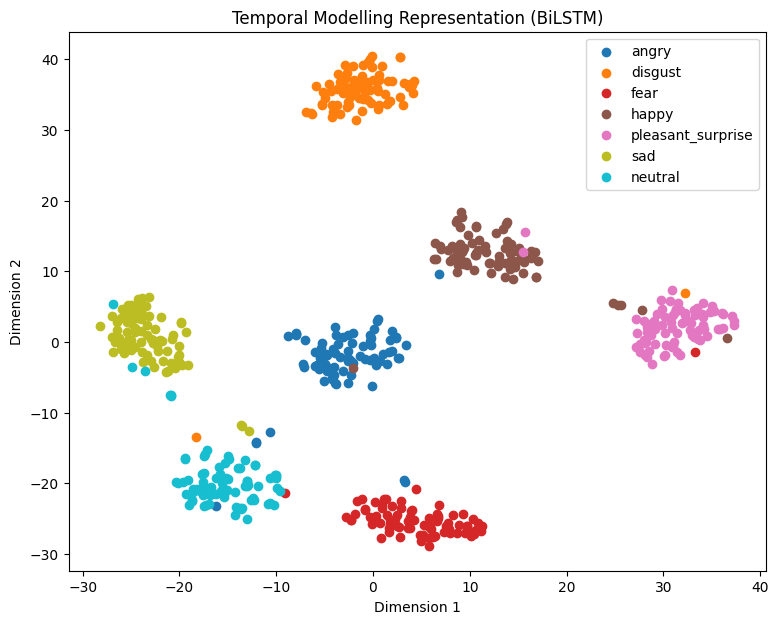

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

emotion_names = [
    "angry",
    "disgust",
    "fear",
    "happy",
    "pleasant_surprise",
    "sad",
    "neutral"
]

tsne = TSNE(n_components=2, random_state=42)
temp_2d = tsne.fit_transform(temporal_features)

plt.figure(figsize=(9,7))

colors = plt.cm.tab10(np.linspace(0,1,7))

for i in range(7):
    idx = np.where(np.array(test_labels) == i)
    plt.scatter(
        temp_2d[idx,0],
        temp_2d[idx,1],
        label=emotion_names[i],
        color=colors[i]
    )

plt.title("Temporal Modelling Representation (BiLSTM)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend()
plt.show()


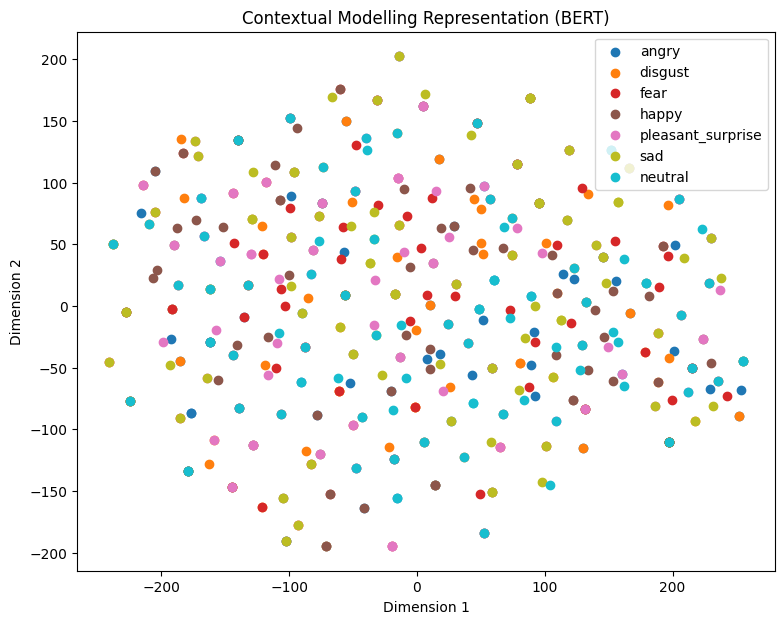

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

emotion_names = [
    "angry",
    "disgust",
    "fear",
    "happy",
    "pleasant_surprise",
    "sad",
    "neutral"
]

tsne = TSNE(n_components=2, random_state=42)
context_2d = tsne.fit_transform(context_features)

plt.figure(figsize=(9,7))

colors = plt.cm.tab10(np.linspace(0,1,7))

for i in range(7):
    idx = np.where(np.array(test_labels) == i)
    plt.scatter(
        context_2d[idx,0],
        context_2d[idx,1],
        label=emotion_names[i],
        color=colors[i]
    )

plt.title("Contextual Modelling Representation (BERT)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend()
plt.show()


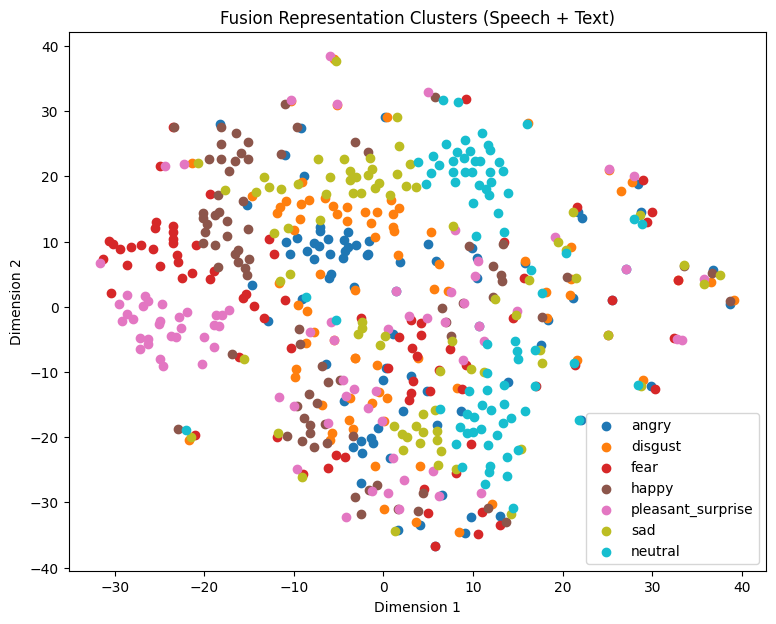

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

emotion_names = [
    "angry",
    "disgust",
    "fear",
    "happy",
    "pleasant_surprise",
    "sad",
    "neutral"
]

tsne = TSNE(n_components=2, random_state=42)
fusion_2d = tsne.fit_transform(fusion_features)

plt.figure(figsize=(9,7))

colors = plt.cm.tab10(np.linspace(0,1,7))

for i in range(7):
    idx = np.where(np.array(test_labels) == i)
    plt.scatter(
        fusion_2d[idx,0],
        fusion_2d[idx,1],
        label=emotion_names[i],
        color=colors[i]
    )

plt.title("Fusion Representation Clusters (Speech + Text)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend()
plt.show()
